# Ikeda $B_e$ assumtion.
Using analytical linear decay solution to calculate the $B_e$

In [1]:
from rolldecayestimators import equations

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


# Purpose
The quadratic or cubic model can be expressed using the linearized equivalent damping ($B_e$) according to <cite data-cite="7505983/EYEMHSYH">. But I have some doubt about the validity of this, which will be investigated in this notebook.

In [2]:
equations.B_e_equation

Eq(B_e, B_1 + 8*B_2*omega0*phi_a/(3*pi))

# Methodology
The linear equivalent damping is basically about replacing a higher order model with a linear model. In this notebook a quadratic model is representing the higher order model.
The quadratic model has two damping coefficients $B_1$ and $B_2$ these to coefficients should be replaced by only one linear damping term $B_e$. <cite data-cite="7505983/FB64RGPF"></cite> suggests that the equation above can be used to combine $B_1$ and $B_2$ into one coefficient $B_e$.

I will use the least square fitting to find the linear equivalent damping that minimized the error when representing a quadratic model as a linear model. The analytical solution to the linear roll decay model will be used to get a fast and accurate prediction of the least square fit.

# Setup

In [3]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


In [4]:
from rolldecayestimators.simplified_ikeda_class import SimplifiedIkeda
import rolldecayestimators
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares
from rolldecayestimators import fit_on_amplitudes

## Quadratic

In [5]:
Math(vlatex(equations.roll_decay_equation_himeno_quadratic_b))

<IPython.core.display.Math object>

In [6]:
eq_acceleration_quadratic = sp.Eq(symbols.phi_dot_dot,
                        sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

accelaration_quadratic_lambda = lambdify(sp.solve(equations.roll_decay_equation_himeno_quadratic_b,symbols.phi_dot_dot)[0])

Math(vlatex(eq_acceleration_quadratic))

<IPython.core.display.Math object>

In [7]:
class RollDecayQuadratic():
    
    def __init__(self,A_44, B_1, B_2, C_1):
        self.parameters = {
            'A_44':A_44,
            'B_1':B_1,
            'B_2':B_2,
            'C_1':C_1,
        }
            
    def time_step(self,t,states):
        
        phi = states[0]
        phi1d = states[1]
        phi2d = accelaration_quadratic_lambda(**self.parameters, phi=phi, phi1d=phi1d)
        
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt
    
    def simulate(self,t,phi0=np.deg2rad(10),phi1d0=0):
        
        initial_state = [phi0,phi1d0]
        
        t_span = [t[0], t[-1]]
        
        result = solve_ivp(fun=simulation.time_step, t_span=t_span,  y0=initial_state, t_eval=t)
        assert result.success
        df_result = pd.DataFrame(index=result.t, data=result.y.T, columns = ['phi','phi1d'])
        return df_result


## Select suitable parameter range

In [8]:
df_rolldecay = database.load(rolldecay_table_name='rolldecay_quadratic_b', limit_score=0.95, 
                             exclude_table_name='rolldecay_exclude')

In [9]:
interesting = ['B_1A','B_2A','C_1A']
df_rolldecay[interesting].describe()

,B_1A,B_2A,C_1A
count,2.220000e+02,222.000000,222.000000
mean,1.425475e-01,0.281687,9.042803
std,1.071491e-01,0.258985,4.378310
min,6.451552e-18,-0.662927,1.539731
25%,5.792787e-02,0.144445,5.915274
50%,1.167264e-01,0.241128,8.312634
75%,2.092812e-01,0.371055,11.348254
max,5.570938e-01,1.956472,25.363015


In [10]:
B_1A = df_rolldecay['B_1A'].median()
B_1A

0.11672637102335451

In [11]:
index = (df_rolldecay['B_1A']-B_1A).abs().argmin()
row = df_rolldecay.iloc[index]

In [12]:
row['B_1A']

0.118067357553941

In [13]:
B_max_ratio = (df_rolldecay['B_2A']/df_rolldecay['B_1A']).abs().quantile(0.95)

## Create simulation objects with varying $B_2$

In [14]:
N=100000
A_44 = 2.2
B_1 = row['B_1A']*A_44
C_1 = row['C_1A']*A_44

simulations = {
}

N= 15
B_2_max = B_max_ratio*B_1
B_2s = np.linspace(0,B_2_max,N)
for B_2 in B_2s:
    simulations[B_2]=RollDecayQuadratic(A_44=A_44, B_1=B_1, B_2=B_2, C_1=C_1)

In [15]:
B_1

0.2597481866186702

In [16]:
C_1

8.317077640826263

In [17]:
equations.C_equation_linear

Eq(C, GM*g*m)

In [18]:
A_44_eq = sp.Eq(symbols.A_44, equations.A44)
A_44_eq

Eq(A_44, GM*g*m/omega0**2)

In [19]:
eqs = [
    A_44_eq,
    equations.C_equation_linear,

]
omega0_eq = sp.Eq(symbols.omega0,sp.solve(eqs, symbols.omega0, symbols.GM)[1][0])
omega0_eq

Eq(omega0, sqrt(C/A_44))

## Simulate with all simulation objects

In [20]:
omega0 = np.sqrt(C_1/A_44)
N_oscillations=10
t = np.arange(0,2*np.pi/omega0*N_oscillations,0.01)
phi0=np.deg2rad(10)
phi1d0 = 0
initial_state = [phi0,phi1d0]


results = {}
X_amplitudes = {}
for name,simulation in simulations.items():
    
    df_result = simulation.simulate(t=t, phi0=phi0, phi1d0=phi1d0)
    
    results[name]=df_result
    X_amplitudes[name]=rolldecayestimators.measure.calculate_amplitudes_and_damping(X=df_result)

In [21]:
omega0

1.9443481778578677

## $B_e$ from anayltica solution

In [22]:
Math(vlatex(equations.diff_eq))

<IPython.core.display.Math object>

In [23]:
Math(vlatex(equations.analytical_solution))

<IPython.core.display.Math object>

In [24]:
no_initial_speed = sp.simplify(equations.analytical_solution.subs(symbols.phi_0_dot,0))
Math(vlatex(no_initial_speed))

<IPython.core.display.Math object>

In [25]:
no_initial_speed_zeta_small = no_initial_speed.subs(
    [(sp.sqrt(1-symbols.zeta**2),1),
     (symbols.zeta*sp.sin(symbols.omega0*symbols.t),0),
    ])
Math(vlatex(no_initial_speed_zeta_small))

<IPython.core.display.Math object>

In [26]:
B_1_zeta_eq = sp.Eq(symbols.B_1, 2*symbols.zeta*symbols.omega0*symbols.A_44)
B_1_zeta_eq

Eq(B_1, 2*A_44*omega0*zeta)

In [27]:
eqs = [
    B_1_zeta_eq,    
    equations.analytical_solution,
      ]

analytical_solution_B_1 = sp.Eq(symbols.phi,
                                sp.simplify(sp.solve(eqs,symbols.zeta,symbols.phi)[0][1]))
analytical_solution_B_1

Eq(phi(t), (4*A_44**2*omega0**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) + 2*A_44**2*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2)*Derivative(phi_0(t), t) + A_44*B_1*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*phi_0(t)*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) - B_1**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2))*exp(-B_1*t/(2*A_44))/(4*A_44**2*omega0**2 - B_1**2))

In [28]:
analytical_lambda = lambdify(sp.solve(analytical_solution_B_1,symbols.phi)[0])

In [29]:
equations.extinction_equation

Eq(phi_a, phi_0(t)*exp(-omega0*t*zeta))

In [30]:
sp.Eq(symbols.zeta,sp.solve(equations.extinction_equation,symbols.zeta)[0])

Eq(zeta, log(phi_0(t)/phi_a)/(omega0*t))

In [31]:
def simulate(B_e,X,omega0,A_44):
    t = X.index
    initial_states = X.iloc[0]
    phi_0 = initial_states['phi']
    phi_01d= initial_states['phi1d']
    phi_pred = analytical_lambda(omega0=omega0, A_44=A_44, phi_0=phi_0, phi_01d=phi1d0, t=t, B_1=B_e)
    return phi_pred

def residuals(B_e,X,omega0,A_44):
    
    phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
    residual = phi_pred - X['phi']
    return residual

In [32]:
def linear_equivalent(X,omega0,A_44):
    kwargs={
        'X':X,
        'omega0':omega0,
        'A_44':A_44,
    }
    initial_guess = [B_1]
    result = least_squares(fun=residuals, x0=initial_guess, kwargs=kwargs, method='lm')
    assert result.success is True
    B_e = result.x[0]
    return B_e

0.9999674201528168

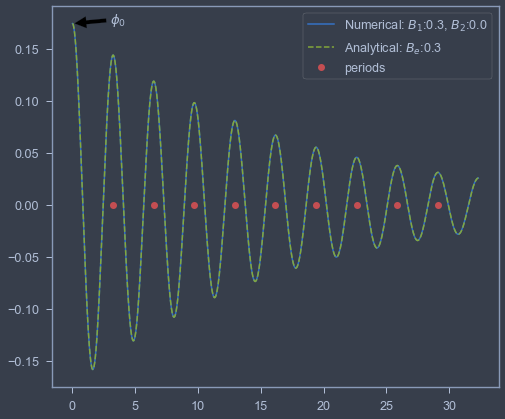

In [33]:
B_2 = 0
X = results[B_2]
omega0 = np.sqrt(C_1/A_44)
simulation = simulations[B_2]

B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
phi_error = X['phi'] - phi_pred

fig,ax=plt.subplots()

label = r'Numerical: $B_1$:%0.1f, $B_2$:%0.1f' % (simulation.parameters['B_1'],simulation.parameters['B_2'])
X.plot(y='phi',ax=ax, label=label)
label = r'Analytical: $B_e$:%0.1f' % B_e
ax.plot(t,phi_pred,'--', label=label)

## Helpers:
ax.annotate(r'$\phi_0$',xy=(0,phi0), 
            xytext=(3,phi0), arrowprops=dict(facecolor='black', shrink=0.05))

t0 = 2*np.pi/omega0
t0s = np.arange(t0,np.max(t),t0)
ax.plot(t0s,np.zeros(len(t0s)), 'ro', label='periods')

ax.legend()

r2_score(y_true=X['phi'], y_pred=phi_pred)

In [34]:
df_B_e = pd.DataFrame()
df_B_e.index.name='B_2'

for B_2, X in results.items():
    B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'B_e'] = B_e
    phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2'] = r2_score(y_true=X['phi'], y_pred=phi_pred)
    
    B_e_himeno = lambdas.B_e_lambda(B_1=B_1, B_2=B_2, omega0=omega0, phi_a=phi0)
    df_B_e.loc[B_2,'B_e_himeno'] = B_e_himeno
    phi_pred_himeno = simulate(B_e=B_e_himeno, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2_himeno'] = r2_score(y_true=X['phi'], y_pred=phi_pred_himeno)

df_B_e['B_1'] = B_1

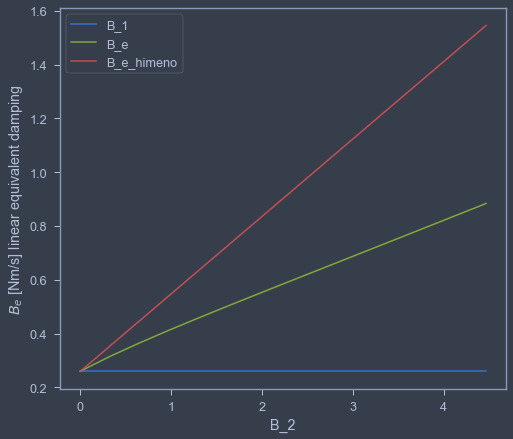

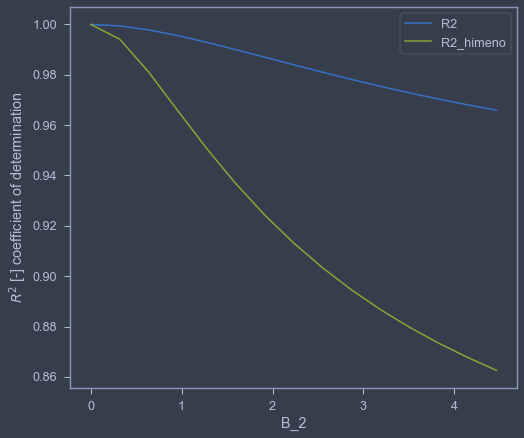

In [35]:
fig,ax=plt.subplots()
df_B_e.plot(y=['B_1','B_e','B_e_himeno'], ax=ax)
ax.set_ylabel('$B_e$ [Nm/s] linear equivalent damping')

fig,ax=plt.subplots()
df_B_e.plot(y=['R2','R2_himeno'],ax=ax)
ax.set_ylabel('$R^2$ [-] coefficient of determination')
ylim = ax.get_ylim()

## $B_2/2$

In [36]:
df_B_e = pd.DataFrame()
df_B_e.index.name='B_2'

for B_2, X in results.items():
    B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'B_e'] = B_e
    phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2'] = r2_score(y_true=X['phi'], y_pred=phi_pred)
    
    B_e_himeno = lambdas.B_e_lambda(B_1=B_1, B_2=B_2/2, omega0=omega0, phi_a=phi0)
    df_B_e.loc[B_2,'B_e_himeno'] = B_e_himeno
    phi_pred_himeno = simulate(B_e=B_e_himeno, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2_himeno'] = r2_score(y_true=X['phi'], y_pred=phi_pred_himeno)

df_B_e['B_1'] = B_1

(0.8557383802505134, 1.0068354696719741)

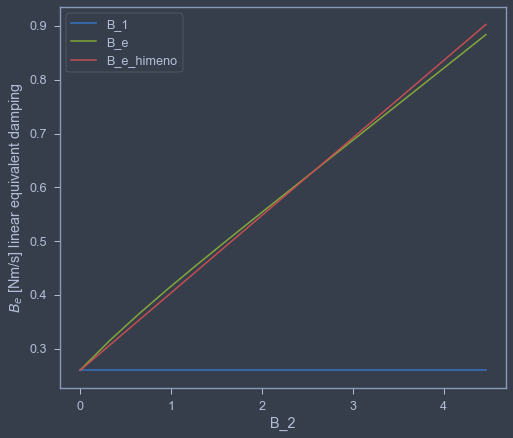

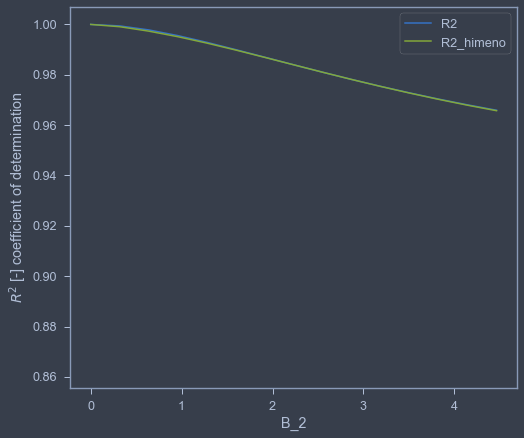

In [37]:
fig,ax=plt.subplots()
df_B_e.plot(y=['B_1','B_e','B_e_himeno'], ax=ax)
ax.set_ylabel('$B_e$ [Nm/s] linear equivalent damping')

fig,ax=plt.subplots()
df_B_e.plot(y=['R2','R2_himeno'],ax=ax)
ax.set_ylabel('$R^2$ [-] coefficient of determination')
ax.set_ylim(ylim)

## $\frac{\phi_a}{2}$

In [38]:
df_B_e = pd.DataFrame()
df_B_e.index.name='B_2'

for B_2, X in results.items():
    B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'B_e'] = B_e
    phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2'] = r2_score(y_true=X['phi'], y_pred=phi_pred)
    
    B_e_himeno = lambdas.B_e_lambda(B_1=B_1, B_2=B_2, omega0=omega0, phi_a=phi0/2)
    df_B_e.loc[B_2,'B_e_himeno'] = B_e_himeno
    phi_pred_himeno = simulate(B_e=B_e_himeno, X=X, omega0=omega0, A_44=A_44)
    df_B_e.loc[B_2,'R2_himeno'] = r2_score(y_true=X['phi'], y_pred=phi_pred_himeno)

df_B_e['B_1'] = B_1

(0.8557383802505134, 1.0068354696719741)

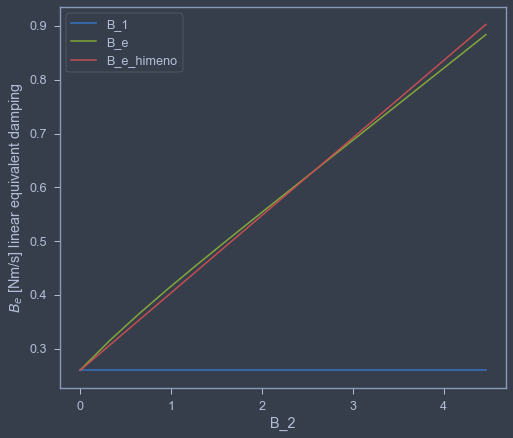

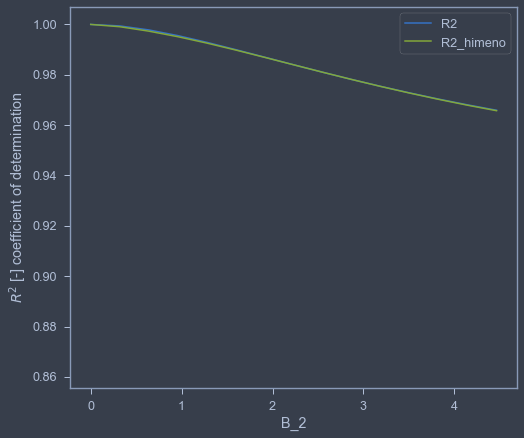

In [39]:
fig,ax=plt.subplots()
df_B_e.plot(y=['B_1','B_e','B_e_himeno'], ax=ax)
ax.set_ylabel('$B_e$ [Nm/s] linear equivalent damping')

fig,ax=plt.subplots()
df_B_e.plot(y=['R2','R2_himeno'],ax=ax)
ax.set_ylabel('$R^2$ [-] coefficient of determination')
ax.set_ylim(ylim)

<AxesSubplot:>

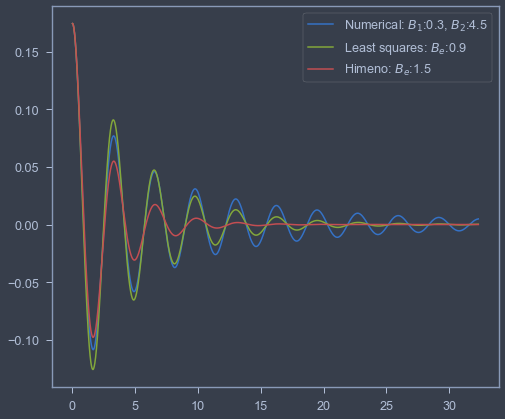

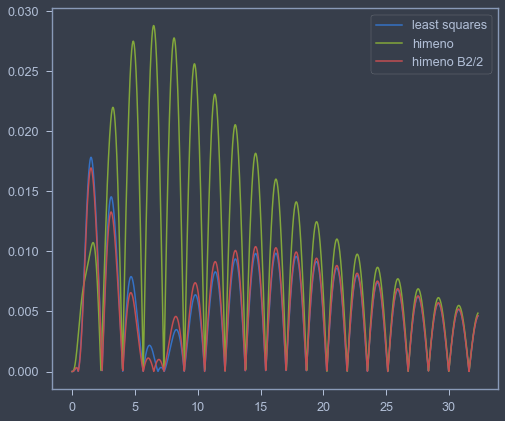

In [40]:
X = results[B_2]
simulation = simulations[B_2]
df_error = pd.DataFrame(index=t)

B_e = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
phi_pred = simulate(B_e=B_e, X=X, omega0=omega0, A_44=A_44)
df_error['least squares'] = (X['phi'] - phi_pred).abs()


B_e_himeno = lambdas.B_e_lambda(B_1=B_1, B_2=B_2, omega0=omega0, phi_a=phi0)
phi_pred_himeno = simulate(B_e=B_e_himeno, X=X, omega0=omega0, A_44=A_44)
df_error['himeno'] = (X['phi'] - phi_pred_himeno).abs()

B_e_himeno2 = lambdas.B_e_lambda(B_1=B_1, B_2=B_2/2, omega0=omega0, phi_a=phi0)
phi_pred_himeno2 = simulate(B_e=B_e_himeno2, X=X, omega0=omega0, A_44=A_44)
df_error['himeno B2/2'] = (X['phi'] - phi_pred_himeno2).abs()

fig,ax=plt.subplots()

label = r'Numerical: $B_1$:%0.1f, $B_2$:%0.1f' % (simulation.parameters['B_1'],simulation.parameters['B_2'])
X.plot(y='phi',ax=ax, label=label)

label = r'Least squares: $B_e$:%0.1f' % B_e
ax.plot(t, phi_pred, label=label)

label = r'Himeno: $B_e$:%0.1f' % B_e_himeno
ax.plot(t, phi_pred_himeno, label=label)
ax.legend()

fig,ax=plt.subplots()
df_error.plot(ax=ax)

## And time domain

In [41]:
simulation = simulations[B_2]
X = simulation.simulate(t=t)

df_B = pd.DataFrame(columns=simulation.parameters.keys())
df_B.loc['simulation'] = simulation.parameters

name = 'least square'
s = pd.Series(name=name)
s['B_1'] = linear_equivalent(X=X, omega0=omega0, A_44=A_44)
s['B_2'] = 0
df_B.loc[name] = s

name = 'himeno'
s = pd.Series(name=name)
s['B_1'] = lambdas.B_e_lambda(B_1=B_1, B_2=B_2, omega0=omega0, phi_a=phi0)
s['B_2'] = 0
df_B.loc[name] = s

df_B.fillna(method='pad', inplace=True)
df_B

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,A_44,B_1,B_2,C_1
simulation,2.2,0.259748,4.464729,8.317078
least square,2.2,0.883862,0.000000,8.317078
himeno,2.2,1.545820,0.000000,8.317078


In [42]:
results_ = pd.DataFrame()

for index, row in df_B.iterrows():
    simulation = RollDecayQuadratic(**row)
    X = simulation.simulate(t=t)
    X['model'] = index
    results_=results_.append(X)

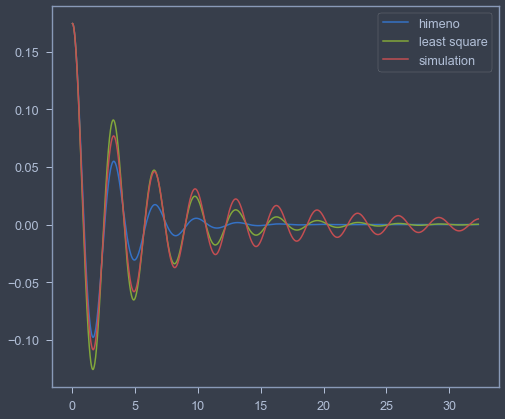

In [43]:
fig,ax = plt.subplots()
groups = results_.groupby(by='model')
for model,df_ in groups:
    df_.plot(y='phi', ax=ax, label=model)

## Looking at amplitudes

In [44]:
B_1_zeta_eq

Eq(B_1, 2*A_44*omega0*zeta)

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='phi_a'>

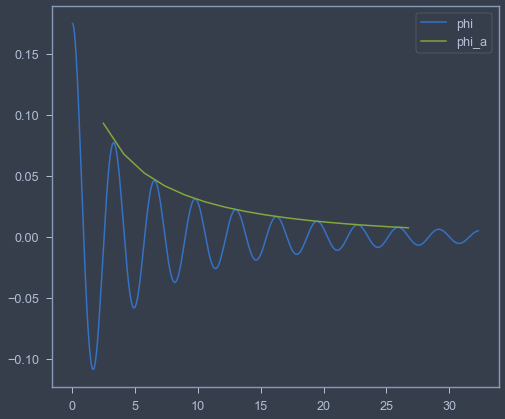

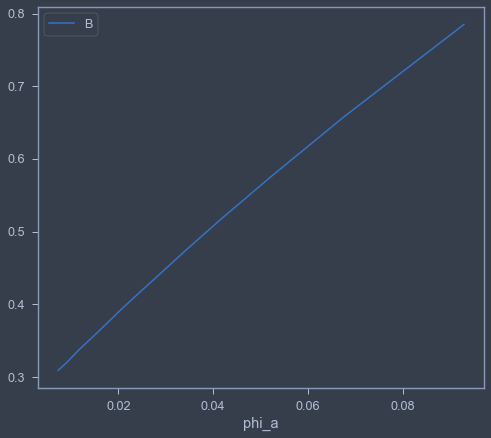

In [45]:
X = groups.get_group('simulation')
X.drop(columns='model', inplace=True)
amplitudes = rolldecayestimators.measure.calculate_amplitudes_and_damping(X=X)
amplitudes.dropna(inplace=True)
zeta = amplitudes['zeta_n']
amplitudes['B']=2*A_44*omega0*zeta

fig,ax=plt.subplots()
X.plot(y='phi', ax=ax)
amplitudes.plot(y='phi_a', ax=ax)

fig,ax=plt.subplots()
amplitudes.plot(x='phi_a',y='B', ax=ax)

In [46]:
parameters = fit_on_amplitudes.fit_quadratic(y=amplitudes['B'], 
                            phi_a=amplitudes['phi_a'], 
                            omega0=amplitudes['omega0'],
                           )

name = 'amplitude'
s = pd.Series(name=name)
s['B_1'] = parameters['B_1']
s['B_2'] = parameters['B_2']
df_B.loc[name] = s


parameters = fit_on_amplitudes.fit_quadratic(y=amplitudes['B'], 
                            phi_a=amplitudes['phi_a']/2, 
                            omega0=amplitudes['omega0'],
                           )
name = 'amplitude2'
s = pd.Series(name=name)
s['B_1'] = parameters['B_1']
s['B_2'] = parameters['B_2']
df_B.loc[name] = s


df_B.fillna(method='pad', inplace=True)
df_B

c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys
c:\dev\prediction-of-roll-damping-using-fully-nonlinear-potential-flow-and-ikedas-method\venv\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,A_44,B_1,B_2,C_1
simulation,2.2,0.259748,4.464729,8.317078
least square,2.2,0.883862,0.000000,8.317078
himeno,2.2,1.545820,0.000000,8.317078
amplitude,2.2,0.273079,3.448405,8.317078
amplitude2,2.2,0.273079,6.896809,8.317078


In [47]:
results_ = pd.DataFrame()

for index, row in df_B.iterrows():
    simulation = RollDecayQuadratic(**row)
    X = simulation.simulate(t=t)
    X['model'] = index
    results_=results_.append(X)

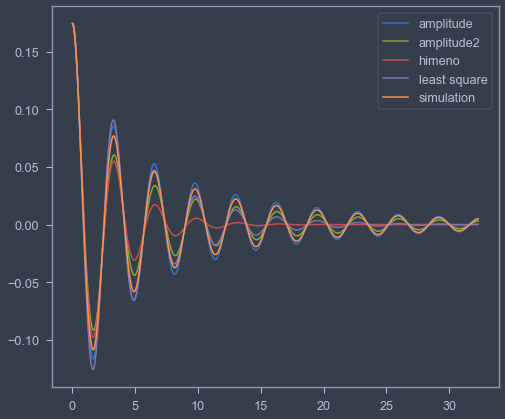

In [48]:
fig,ax = plt.subplots()
groups = results_.groupby(by='model')
df_error = pd.DataFrame(index=t)

for model,df_ in groups:
    df_.plot(y='phi', ax=ax, label=model)
    
    df_error[model] = (df_['phi'] - groups.get_group('simulation')['phi']).abs()

<AxesSubplot:>

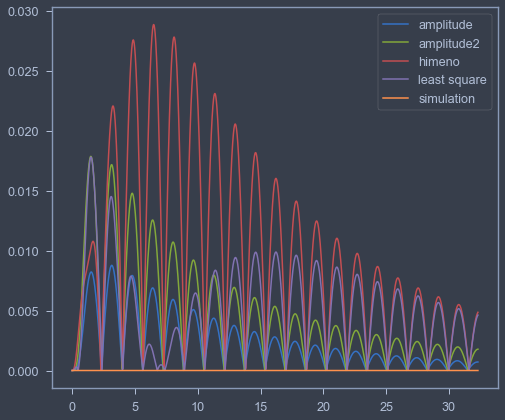

In [49]:
df_error.plot()